In [4]:
import yfinance as yf
import pandas as pd

'''
This code cell is downloads stock market data from the previous 25 years.

It then saves the csv files locally, loads them as a pandas DataFrame, and organizes the dataframe properly.

Once the SP500 and VIX data has been cleaned and saved, a new dataframe is created that takes only the 
adjusted close valuesfrom the SP500 and VIX.

It merges the SP500 and VIX adj close data and saves it into merged_adj_closings.csv

'''

# Change window of stock market data to be analyzed
start_date = "2000-01-01"
end_date = "2025-01-01"

# Downloading data from S&P 500 and Volatility Index
sp500 = yf.download("^GSPC", start=start_date, end=end_date, auto_adjust=False)
vix = yf.download("^VIX", start=start_date, end=end_date, auto_adjust=False)

# Save locally to data folder
sp500.to_csv("../data/sp500.csv")
vix.to_csv("../data/vix.csv")

# Load as DataFrame
sp500 = pd.read_csv("../data/sp500.csv")
vix = pd.read_csv("../data/vix.csv")

# Reorganize DataFrame
sp500 = sp500.drop(0)
sp500 = sp500.drop(1)
sp500 = sp500.rename(columns={'Price': 'Dates'})
vix = vix.drop(0)
vix = vix.drop(1)
vix = vix.rename(columns={'Price': 'Dates'})

# Save locally again
sp500.to_csv("../data/sp500.csv")
vix.to_csv("../data/vix.csv")

def print_both():
    print(sp500.head(5))
    print("")
    print(vix.head(5))
    return

# Use Adj Close as our primary data points and main focus, increased research reliability
sp500 = sp500[['Dates', 'Adj Close']]
vix = vix[['Dates', 'Adj Close']]
sp500 = sp500.rename(columns={'Adj Close': 'SP500'})
vix = vix.rename(columns={'Adj Close': 'VIX'})
data = sp500.merge(vix, how='inner')
print(data.head())

# Fix data types from objects to float64
data['SP500'] = pd.to_numeric(data['SP500'], errors='coerce')
data['VIX'] = pd.to_numeric(data['VIX'], errors="coerce")

# Save new merged dataframe for adj closings
data.to_csv("../data/merged_adj_closings.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

        Dates               SP500                 VIX
0  2000-01-03   1455.219970703125  24.209999084472656
1  2000-01-04  1399.4200439453125  27.010000228881836
2  2000-01-05  1402.1099853515625   26.40999984741211
3  2000-01-06   1403.449951171875  25.729999542236328
4  2000-01-07   1441.469970703125  21.719999313354492


In [5]:
import numpy as np

# Daily log return
data['log_return'] = np.log(data['SP500'] / data['SP500'].shift(1))

# Rolling volatility (20-day)
data['volatility'] = data['log_return'].rolling(window=20).std()

# 10-day momentum
data['momentum_10'] = data['SP500'] / data['SP500'].shift(10) - 1

# Simple Moving Averages (SMA)
data['sma_50'] = data['SP500'].rolling(window=50).mean()
data['sma_200'] = data['SP500'].rolling(window=200).mean()
data['sma_diff'] = data['sma_50'] - data['sma_200']

# Relative Strength Index (RSI)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

data['14_day_rsi'] = compute_rsi(data['SP500'])

# Drop NaNs and unnamed columns from indicators
features = data.dropna()

# Save to CSV
features.to_csv("../data/features.csv")

# Load the data
features = pd.read_csv("../data/features.csv")

# Drop non-feature columns
feature_cols = features.drop(columns=["Unnamed: 0", "Dates"])

# Check Data Formatting
if (
    not feature_cols.isnull().values.any()
    and (feature_cols.dtypes == 'float64').all()
):
    print("Data is clean and ready for modeling!")
else:
    raise TypeError("Data check failed: All feature columns must be non-null and of type float64.")

Data is clean and ready for modeling!


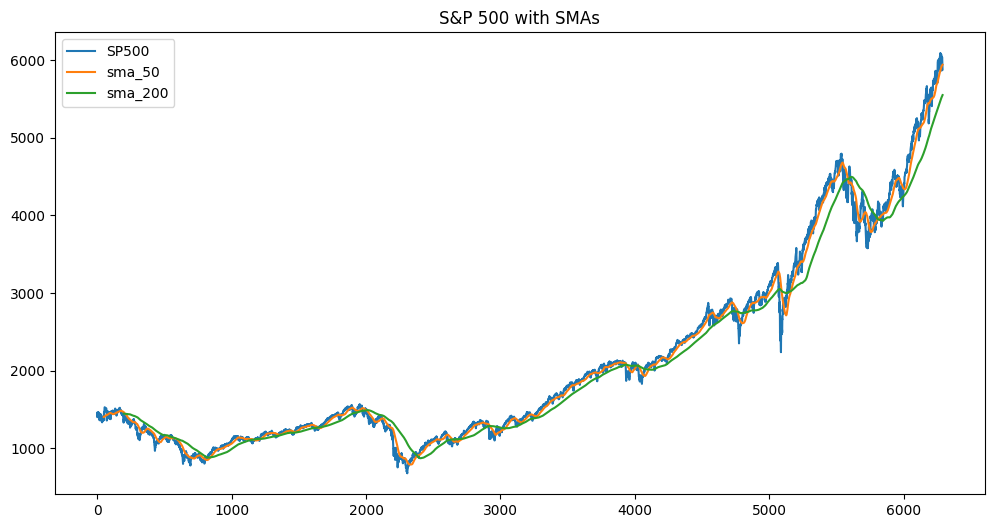

In [6]:
import matplotlib.pyplot as plt

data[['SP500', 'sma_50', 'sma_200']].plot(figsize=(12, 6), title="S&P 500 with SMAs")
plt.show()